In [32]:
import datetime as dt
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deep_hvac import agent, ppo, runner, simulator, util
import importlib
importlib.reload(ppo)
importlib.reload(runner)
importlib.reload(simulator)
importlib.reload(util)



<module 'deep_hvac.util' from '/home/oski/github/6-484-proj/deep_hvac/util.py'>

In [2]:
expert = pd.read_pickle('../data/results-expert-very_light-summer.pickle')
expert_frame = util.load_expert_performance(expert)

In [3]:
env, env_name = runner.make_default_env(
    discrete_action=True, expert_performance=expert['expert_performance'],
    season='summer', capacitance='light')

2022-05-03 22:42:16,335 - deep_hvac - DEBUG - Creating environment DefaultBuilding-light-action-discrete-summer-discomf-terminate-True-v0.
2022-05-03 22:42:16,336 - deep_hvac - DEBUG - Loading NSRDB data from /home/oski/github/6-484-proj/deep_hvac/../data/1704559_29.72_-95.35_2018.csv
2022-05-03 22:42:16,627 - deep_hvac - DEBUG - Loading Houston price data from /home/oski/github/6-484-proj/deep_hvac/../data/houston-2018-prices.pickle


[INFO][2022-05-03 22:42:16]: Creating 1 environments.


2022-05-03 22:42:16,643 - deep_hvac - DEBUG - Creating environment DefaultBuilding-light-v0-action-continuous-summerdiscomf-terminate-True-v0.
2022-05-03 22:42:16,644 - deep_hvac - DEBUG - Loading NSRDB data from /home/oski/github/6-484-proj/deep_hvac/../data/1704559_29.72_-95.35_2018.csv


/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/easyrl/envs/dummy_vec_env.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.buf_dones = np.zeros((self.num_envs,), dtype=np.bool)


2022-05-03 22:42:16,926 - deep_hvac - DEBUG - Loading Houston price data from /home/oski/github/6-484-proj/deep_hvac/../data/houston-2018-prices.pickle


[INFO][2022-05-03 22:42:16]: Creating 1 environments.
/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/easyrl/envs/dummy_vec_env.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.bu

In [4]:
ppoagent, _ = ppo.load_agent(
    f'../data/bc-ppo-tune-DefaultBuilding-very_light-action-discrete-summer-discomf-terminate-True-v0/seed_0/model/model_best.pt',
    env_name)

[INFO][2022-05-03 22:42:16]: Creating 1 environments.
[INFO][2022-05-03 22:42:16]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-05-03 22:42:16]: Loading model from ../data/bc-ppo-tune-DefaultBuilding-very_light-action-discrete-summer-discomf-terminate-True-v0/seed_0/model/model_best.pt


In [37]:
def results_to_dataframes(results_dict):
    out = {}
    for k, v in results_dict.items():
        if k == 'timestamp':
            continue
        out[k] = pd.DataFrame(
            np.array(v).T,
            index=results_dict['timestamp'][0]
        )

    return pd.concat(out.values(), axis=1, keys=out.keys())


def comfort_violations(frame):
    """Return dataframe with comfort penalty scores."""
    frame = frame.copy()
    frame['occupied'] =  [
        simulator.is_occupied(ts) for ts in frame.index
    ]
    if isinstance(frame.columns, pd.MultiIndex):
        for episode in frame['t_outside'].columns:
            frame[('comfort_penalty', episode)] = frame.apply(
                lambda row: (simulator.comfort_penalty(
                    row['t_outside'][episode],
                    row['t_inside'][episode]) * row['occupied'][0]),
                axis=1
            )
            frame[('comfort violation severe', episode)] = (
                frame[('comfort_penalty', episode)] >= 1
            )
            frame[('comfort violation moderate', episode)] = (
                (frame[('comfort_penalty', episode)] < 1) &
                (frame[('comfort_penalty', episode)] >= 0.5)
            )
    else:
        frame['comfort_penalty'] = frame.apply(
            lambda row: simulator.comfort_penalty(
                row['t_outside'], row['t_inside']
            ) * row['occupied'], axis=1
        )
        frame['comfort violation severe'] = (
            frame['comfort_penalty'] >= 1
        )
        frame['comfort violation moderate'] = (
            (frame['comfort_penalty'] < 1) &
            (frame['comfort_penalty'] >= 0.5)
        )

    return frame

In [31]:
jan1 = dt.datetime(2018, 1, 1, 0, 0)
monthly_results = {}
monthly_results_comfort_agent = {}
n_runs = 5
for month in (7, 8, 9):
    start = dt.datetime(2018, month, 1, 0, 0)
    start_int = int((start - jan1).total_seconds() / 3600)
    results = runner.get_results(ppoagent, env, time=start_int,
                                 max_steps=24*30*n_runs)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        monthly_results_comfort_agent[month] = \
            results_to_dataframes(
                runner.get_results(
                    agent.AshraeComfortAgent(env=env),
                    env, time=start_int, max_steps=24*30
                )
            )
    monthly_results[month] = results_to_dataframes(results)

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.88466667 28.88466667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.78391667 28.78391667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.6935 28.6935].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.647 28.647].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.98025 28.98025].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.68291667 29.68291667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete act

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.32383333 29.32383333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.205 29.205].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.1275 29.1275].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.112 29.112].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.15075 29.15075].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.25666667 29.25666667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but re

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.4065 29.4065].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.856 29.856].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.06266667 30.06266667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.19958333 30.19958333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.33908333 30.33908333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.40883333 30.40883333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discre

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.5455 30.5455].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.67983333 30.67983333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.70308333 30.70308333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.61783333 30.61783333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.46025 30.46025].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.375 30.375].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete act

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [24.313 31.313].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [24.13733333 31.13733333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.88158333 30.88158333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.724 30.724].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.82758333 29.82758333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.69583333 29.69583333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.95625 30.95625].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.685 30.685].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.55866667 30.55866667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.80433333 29.80433333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.577 29.577].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.87175 28.87175].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but 

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.352 30.352].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.04975 30.04975].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.78625 29.78625].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.58991667 29.58991667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.42458333 29.42458333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.19466667 29.19466667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete a

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.29541667 29.29541667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.267 29.267].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.30833333 29.30833333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.93608333 29.93608333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [24.42175 29.42175].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [24.89966667 29.89966667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects disc

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.15308333 30.15308333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.85083333 29.85083333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.6235 29.6235].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.03708333 29.03708333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.86141667 28.86141667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.78133333 28.78133333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expe

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.91541667 29.91541667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.8095 29.8095].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.63408333 28.63408333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.38608333 28.38608333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.26725 28.26725].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.19233333 28.19233333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects di

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [26.01825 31.01825].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.60233333 30.60233333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.344 30.344].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.321 30.321].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.77075 29.77075].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.515 29.515].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.83016667 29.83016667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.6235 29.6235].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.453 29.453].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.32125 29.32125].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.21791667 29.21791667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.13525 29.13525].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action bu

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.85341667 28.85341667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [24.1815 29.1815].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [24.53283333 29.53283333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [24.87383333 29.87383333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.16575 30.16575].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.406 30.406].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete act

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.17116667 30.17116667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.7165 29.7165].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.4995 29.4995].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.19983333 29.19983333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.08875 29.08875].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.98283333 28.98283333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete a

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.54058333 30.54058333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.19958333 30.19958333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.01358333 30.01358333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.86633333 29.86633333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.74491667 29.74491667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.62866667 29.62866667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: 

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.367 32.367].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.274 32.274].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.04925 32.04925].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [24.69791667 31.69791667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [24.468 31.468].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.64133333 30.64133333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but rece

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [26.55041667 31.55041667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [26.274 31.274].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.85316667 30.85316667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.042 30.042].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.639 29.639].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.38583333 29.38583333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action bu

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [24.33908333 29.33908333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [24.7705 29.7705].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.52225 30.52225].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.75733333 30.75733333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.73925 30.73925].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.55066667 30.55066667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.53 30.53].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.2665 30.2665].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.065 30.065].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.20733333 30.20733333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.86891667 29.86891667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.68808333 29.68808333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action bu

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.515 28.515].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.30058333 29.30058333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.23858333 29.23858333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.20241667 29.20241667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.174 29.174].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.14558333 29.14558333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.34916667 30.34916667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.13991667 30.13991667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [24.8325 29.8325].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.45816667 29.45816667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.34708333 29.34708333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.24891667 29.24891667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expe

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.90741667 30.90741667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.60516667 30.60516667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.414 30.414].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.6545 29.6545].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.04741667 29.04741667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.93633333 28.93633333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discre

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.75783333 28.75783333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.69325 28.69325].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.58475 28.58475].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.26958333 29.26958333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.16883333 29.16883333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.12491667 29.12491667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects 

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.38533333 30.38533333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.46283333 30.46283333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.45766667 30.45766667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.3905 30.3905].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.24066667 30.24066667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [25.096 30.096].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discre

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.11691667 30.11691667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.17633333 30.17633333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.12466667 30.12466667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.0265 30.0265].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.72425 29.72425].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.68833333 28.68833333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects di

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.69116667 26.69116667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.89266667 26.89266667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.2285 27.2285].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.6005 27.6005].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [22.97508333 27.97508333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [23.26958333 28.26958333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects disc

/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.49716667 28.49716667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.40416667 28.40416667].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.3525 28.3525].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.30083333 28.30083333].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.2285 28.2285].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete action but received [21.14325 28.14325].
  warnings.warn(
/home/oski/github/6-484-proj/deep_hvac/simulator.py:275: UserWarning: Env expects discrete a

In [38]:
monthly_results = {k: comfort_violations(v)
                   for k, v in monthly_results.items()}
comfort_control_frame = {
    k: comfort_violations(v)
    for k, v in monthly_results_comfort_agent.items()
}
expert_frame = comfort_violations(expert_frame)

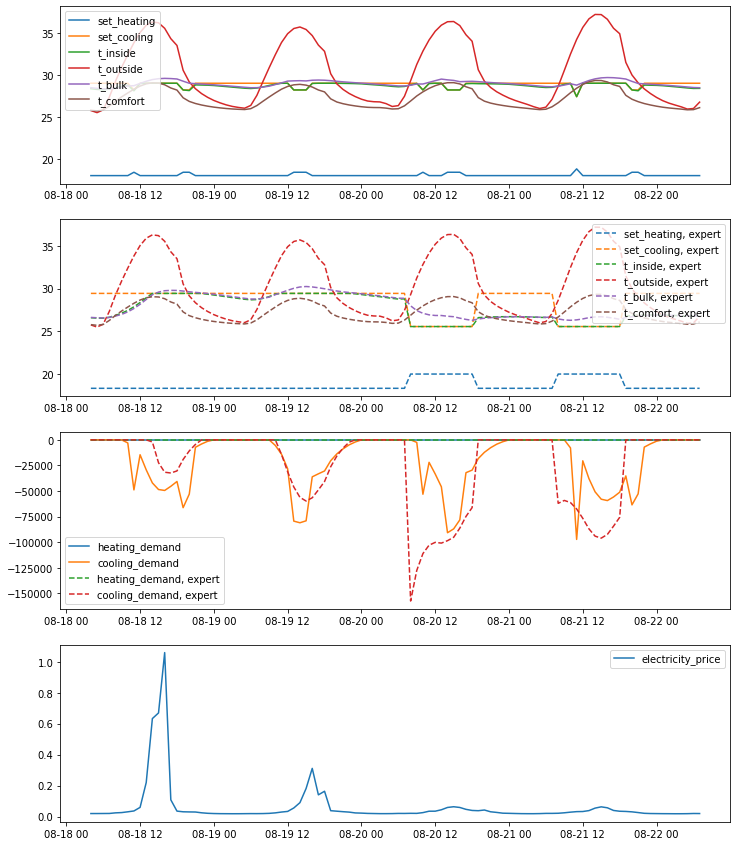

In [34]:
def plot_month(month, monthlies, fields, idx_start=0, n_points=None):
    data = monthlies[month]
    if n_points:
        data = data.iloc[idx_start:idx_start + n_points, :]
    timestamps = data.index
    for field in fields:
        plt.plot(timestamps, data[field].mean(axis=1).values,
                 label=field)
    plt.legend()


def plot_expert(expert, month, monthlies, fields, idx_start=0,
                n_points=None, linestyle='solid'):
    if n_points is None:
        end = None
    else:
        end = n_points + idx_start
    times = monthlies[month].index[
        slice(idx_start, end)
    ]
    for field in fields:
        plt.plot(times, expert.loc[times, field],
                 label=field + ', expert', linestyle=linestyle)
    plt.legend()
    

    
start = 410
month = 8
    
fig, axs = plt.subplots(4, figsize=(12, 15))
plt.sca(axs[0])
plot_month(month, monthly_results,
           ('set_heating', 'set_cooling', 't_inside', 't_outside',
            't_bulk',
            't_comfort'),
           idx_start=start,
           n_points=100)
plt.sca(axs[1])
plot_expert(expert_frame, month, monthly_results,
            ('set_heating', 'set_cooling', 't_inside', 't_outside',
             't_bulk',
             't_comfort'),
            idx_start=start, n_points=100, linestyle='dashed')
plt.sca(axs[2])
plot_month(month, monthly_results,
           ('heating_demand', 'cooling_demand'),
           idx_start=start,
           n_points=100)
plot_expert(expert_frame, month, monthly_results,
            ('heating_demand', 'cooling_demand'),
            idx_start=start, n_points=100, linestyle='dashed')
plt.sca(axs[3])

plot_month(month, monthly_results,
           ('electricity_price',),
           idx_start=start,
           n_points=100)

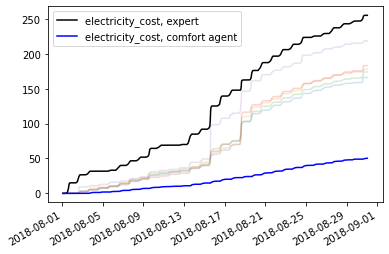

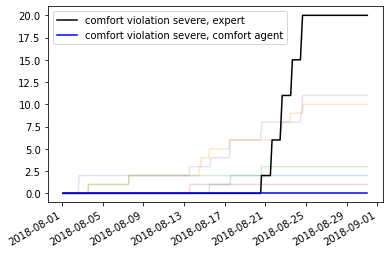

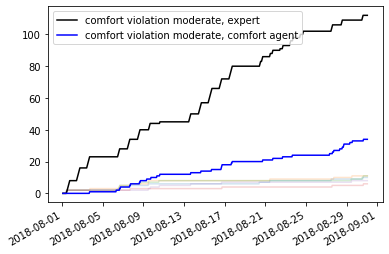

In [39]:
def compare_cumsum(month, monthlies, fields, expert_frame,
                   comfort_frame=None,
                   idx_start=0, n_points=None):
    data = monthlies[month]
    if n_points is not None:
        indexer = slice(idx_start, idx_start + n_points)
    else:
        indexer = slice(idx_start, None)
    data = data.iloc[indexer, :]
    timestamps = data.index
    for field in fields:
        plt.plot(timestamps, data[field].cumsum().values,
                 alpha=0.2)
        expert_frame.loc[timestamps, field].cumsum().plot(
            label=f'{field}, expert', color='k')
        if comfort_frame is not None:
            comfort_month = comfort_frame[month]
            plt.plot(
                timestamps,
                comfort_month.iloc[indexer][field].cumsum().values,
                label=f'{field}, comfort agent', color='b'
            )
    plt.legend()
    
plt.figure()
compare_cumsum(month, monthly_results, ['electricity_cost'],
               expert_frame, comfort_frame=comfort_control_frame,
               idx_start=0, n_points=None)
plt.figure()
compare_cumsum(month, monthly_results, ['comfort violation severe'],
               expert_frame, comfort_frame=comfort_control_frame,
               idx_start=0, n_points=None)
plt.figure()
compare_cumsum(month, monthly_results, ['comfort violation moderate'],
               expert_frame, comfort_frame=comfort_control_frame,
               idx_start=0, n_points=None)

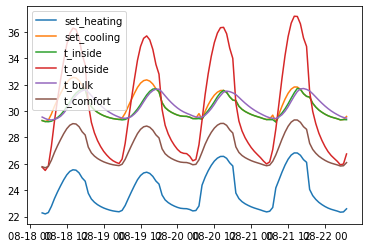

In [40]:
plt.figure()
plot_month(month, comfort_control_frame,
           ('set_heating', 'set_cooling', 't_inside', 't_outside',
            't_bulk',
            't_comfort'),
           idx_start=start,
           n_points=100)